In [1]:
import pandas as pd
import string
import numpy as np
import math

In [2]:
#Process CTT Speed Data
df=pd.read_csv('terbine_visualizations/ctt_crash_visualization/original_visualization_data/ctt_continuous.csv')

dffin=df[[' "_last_updt"',' "street"','segmentid',' "_direction"',' "start_lon"',' "_lif_lat"',' "_lit_lon"',' "_lit_lat"',' "_traffic"']].copy()

cnt=0
newcols=[]
for column in dffin.columns: #rename columns for ease of use
    newcols.append(column.strip(' "'))
    
dffin.columns=newcols
dffin.loc[:,'_last_updt']=pd.to_datetime(dffin['_last_updt'])

dffin=dffin.loc[dffin['_last_updt']>'2020-01-01 00:00:00.0'] #restrict by time period
dffin=dffin.sort_values(by='_last_updt') #sort by date
dffin=dffin.loc[dffin['_traffic']>-1] #remove empty data

In [3]:
dffin #ctt dataframe

_last_updt   street  segmentid _direction  start_lon  \
499336 2020-08-21 18:01:11  Ashland        131         NB -87.669430   
499348 2020-08-21 18:01:11  Ashland        142         SB -87.664960   
499347 2020-08-21 18:01:11  Ashland        141         SB -87.664765   
499346 2020-08-21 18:01:11  Ashland        140         SB -87.664578   
499344 2020-08-21 18:01:11  Ashland        139         SB -87.664404   
...                    ...      ...        ...        ...        ...   
235    2020-08-27 01:10:48  Halsted       1219         NB -87.646517   
234    2020-08-27 01:10:48  Halsted       1218         NB -87.646305   
233    2020-08-27 01:10:48  Halsted       1217         NB -87.646297   
232    2020-08-27 01:10:48  Halsted       1216         NB -87.646086   
202    2020-08-27 01:10:48    Clark       1188         NB -87.669527   

         _lif_lat   _lit_lon   _lit_lat  _traffic  
499336  41.976171 -87.669632  41.983475        18  
499348  41.801319 -87.664765  41.794025        18  
499347  41.794025 -87.664578  41.786748        25  
499346  41.786748 -87.664404  41.779466        33  
499344  41.779466 -87.664204  41.772193        28  
...           ...        ...        ...       ...  
235     41.859912 -87.646729  41.867152        24  
234     41.852646 -87.646517  41.859912        21  
233     41.847196 -87.646305  41.852646        25  
232     41.838046 -87.646297  41.847196        23  
202     41.986752 -87.669800  41.989697        25  

[213248 rows x 9 columns]

In [4]:
#Process Chicago Reported Crash Data
dfcr=pd.read_csv('terbine_visualizations/ctt_crash_visualization/original_visualization_data/crashes.csv')
dfcr['CRASH_DATE']=pd.to_datetime(dfcr['CRASH_DATE'])

#restrict ccolumns to relevant data points
dfcrfin=dfcr[['CRASH_DATE', 'POSTED_SPEED_LIMIT', 'WEATHER_CONDITION','CRASH_TYPE', 'STREET_NAME', 'LATITUDE','LONGITUDE']]

#restrict by min/max dates from CTT Speed --edit here to use dynamic dates
dfcrfin=dfcrfin.loc[(dfcr['CRASH_DATE']>dffin["_last_updt"].min()) & (dfcrfin['CRASH_DATE']<dffin["_last_updt"].max()) ]
#order data
dfcrfin=dfcrfin.sort_values(by='CRASH_DATE')

In [5]:
dfcrfin #crash original dataframe

CRASH_DATE  POSTED_SPEED_LIMIT WEATHER_CONDITION  \
13666 2020-08-21 18:03:00                  30             CLEAR   
13590 2020-08-21 18:04:00                  30             CLEAR   
14686 2020-08-21 18:07:00                  10             CLEAR   
13645 2020-08-21 18:08:00                  30             CLEAR   
13464 2020-08-21 18:09:00                  30             CLEAR   
...                   ...                 ...               ...   
19479 2020-08-26 21:45:00                  30             CLEAR   
19525 2020-08-26 23:38:00                  30             CLEAR   
19528 2020-08-26 23:45:00                  30             CLEAR   
19369 2020-08-27 00:15:00                  30             CLEAR   
19353 2020-08-27 00:55:00                  30             CLEAR   

                             CRASH_TYPE     STREET_NAME   LATITUDE  LONGITUDE  
13666            NO INJURY / DRIVE AWAY    AUGUSTA BLVD  41.898925 -87.724910  
13590  INJURY AND / OR TOW DUE TO CRASH      FOSTER AVE  41.975540 -87.717281  
14686  INJURY AND / OR TOW DUE TO CRASH     WESTERN AVE  41.768182 -87.683485  
13645            NO INJURY / DRIVE AWAY       HOMAN AVE  41.899107 -87.711408  
13464            NO INJURY / DRIVE AWAY    JEFFERY BLVD  41.765816 -87.576145  
...                                 ...             ...        ...        ...  
19479  INJURY AND / OR TOW DUE TO CRASH    ARMITAGE AVE  41.917443 -87.712715  
19525  INJURY AND / OR TOW DUE TO CRASH    MICHIGAN AVE  41.710689 -87.620032  
19528  INJURY AND / OR TOW DUE TO CRASH      KEELER AVE  41.881921 -87.730467  
19369  INJURY AND / OR TOW DUE TO CRASH  CALIFORNIA AVE  41.832134 -87.694728  
19353  INJURY AND / OR TOW DUE TO CRASH         95TH ST  41.721669 -87.636091  

[1215 rows x 7 columns]

In [6]:
#rename date column to match CTT date column, kepler.gl limited to 1 dataset per time slider
dfcrfin=dfcrfin.rename(columns={'CRASH_DATE': '_last_updt'})

In [7]:
dfcrfin["closest_street"]= np.nan #add column to track closest street segment for crash points
dfcrfin["selected"]= np.nan #add colum for filtering results

In [8]:
dfcrfin

_last_updt  POSTED_SPEED_LIMIT WEATHER_CONDITION  \
13666 2020-08-21 18:03:00                  30             CLEAR   
13590 2020-08-21 18:04:00                  30             CLEAR   
14686 2020-08-21 18:07:00                  10             CLEAR   
13645 2020-08-21 18:08:00                  30             CLEAR   
13464 2020-08-21 18:09:00                  30             CLEAR   
...                   ...                 ...               ...   
19479 2020-08-26 21:45:00                  30             CLEAR   
19525 2020-08-26 23:38:00                  30             CLEAR   
19528 2020-08-26 23:45:00                  30             CLEAR   
19369 2020-08-27 00:15:00                  30             CLEAR   
19353 2020-08-27 00:55:00                  30             CLEAR   

                             CRASH_TYPE     STREET_NAME   LATITUDE  LONGITUDE  \
13666            NO INJURY / DRIVE AWAY    AUGUSTA BLVD  41.898925 -87.724910   
13590  INJURY AND / OR TOW DUE TO CRASH      FOSTER AVE  41.975540 -87.717281   
14686  INJURY AND / OR TOW DUE TO CRASH     WESTERN AVE  41.768182 -87.683485   
13645            NO INJURY / DRIVE AWAY       HOMAN AVE  41.899107 -87.711408   
13464            NO INJURY / DRIVE AWAY    JEFFERY BLVD  41.765816 -87.576145   
...                                 ...             ...        ...        ...   
19479  INJURY AND / OR TOW DUE TO CRASH    ARMITAGE AVE  41.917443 -87.712715   
19525  INJURY AND / OR TOW DUE TO CRASH    MICHIGAN AVE  41.710689 -87.620032   
19528  INJURY AND / OR TOW DUE TO CRASH      KEELER AVE  41.881921 -87.730467   
19369  INJURY AND / OR TOW DUE TO CRASH  CALIFORNIA AVE  41.832134 -87.694728   
19353  INJURY AND / OR TOW DUE TO CRASH         95TH ST  41.721669 -87.636091   

       closest_street  selected  
13666             NaN       NaN  
13590             NaN       NaN  
14686             NaN       NaN  
13645             NaN       NaN  
13464             NaN       NaN  
...               ...       ...  
19479             NaN       NaN  
19525             NaN       NaN  
19528             NaN       NaN  
19369             NaN       NaN  
19353             NaN       NaN  

[1215 rows x 9 columns]

In [9]:
#Filter crash data to only streets we have data for below

In [10]:
#makee unique list of street line segments
dffinunique=dffin[['street','segmentid','_direction','start_lon','_lif_lat','_lit_lon','_lit_lat']].drop_duplicates()

In [11]:
#source: https://stackoverflow.com/questions/910882/how-can-i-tell-if-a-point-is-nearby-a-certain-line
#Here's a python function which does the trick.
#It should work in 2 or 3 dimensions (or more) and handles vertical and horizontal lines without special cases.
#If you set clipToSegment to true the returned point is clipped to the ends if the projected line extends beyond the supplied line segment.
def nearestPointOnLine(pt, r0, r1, clipToSegment = True):
    r01 = r1 - r0           # vector from r0 to r1 
    d = np.linalg.norm(r01) # length of r01
    r01u = r01 / d          # unit vector from r0 to r1
    r = pt - r0             # vector from r0 to pt
    rid = np.dot(r, r01u)   # projection (length) of r onto r01u
    ri = r01u * rid         # projection vector
    lpt = r0 + ri           # point on line

    if clipToSegment:       # if projection is not on line segment
        if rid > d:         # clip to endpoints if clipToSegment set
            return r1
        if rid < 0:
            return r0 

    return lpt

#loops through every crash row and attempts to find line segment from CTT data such that the crash
#point is within ~22m (converted from degrees to m at chicag latitude) from the line segment
#degree->m cutoff length acquired from http://www.csgnetwork.com/degreelenllavcalc.html
def filter_fn(row):
    rpt = np.array([row['LONGITUDE'],row['LATITUDE']]) #crash point
    
    for _, rowseg in dffinunique.iterrows():
        r0 = np.array([rowseg["start_lon"],rowseg["_lif_lat"]]) #first traffic line segment point
        r1 = np.array([rowseg["_lit_lon"],rowseg["_lit_lat"]]) #second traffic line segment point
        pt = nearestPointOnLine(rpt, r0, r1, True) #point nearest to crash on road line segment 
    
        dist = np.linalg.norm(rpt-pt) #distance of crash point from line segment
        
        #if distance of a point from a line segment is less than cutoff value,
        #cconsider it "close" to a street seg
        if dist<0.0002:
            row["closest_street"]=rowseg["street"]
            row["selected"]=True
            #print('pass dist', dist, 'crash st name:',row["STREET_NAME"], 'closest CTT segment street:', rowseg["street"])
            return row
    
    #if we have checked all unique segment options, crash is not close
    return row
    
m = dfcrfin.apply(filter_fn, axis=1)
dfcrfinclose = m[m["selected"]==True]

In [12]:
dfcrfinclose

_last_updt  POSTED_SPEED_LIMIT WEATHER_CONDITION  \
14686 2020-08-21 18:07:00                  10             CLEAR   
14634 2020-08-21 18:15:00                  30             CLEAR   
13543 2020-08-21 18:25:00                  30             CLEAR   
14544 2020-08-21 18:35:00                  30             CLEAR   
13443 2020-08-21 18:40:00                  30             CLEAR   
...                   ...                 ...               ...   
19326 2020-08-26 17:21:00                  35             CLEAR   
19450 2020-08-26 18:10:00                  30             CLEAR   
19378 2020-08-26 18:10:00                  15             CLEAR   
19387 2020-08-26 18:25:00                  30             CLEAR   
19353 2020-08-27 00:55:00                  30             CLEAR   

                             CRASH_TYPE       STREET_NAME   LATITUDE  \
14686  INJURY AND / OR TOW DUE TO CRASH       WESTERN AVE  41.768182   
14634            NO INJURY / DRIVE AWAY           79TH ST  41.751272   
13543  INJURY AND / OR TOW DUE TO CRASH        CICERO AVE  41.881884   
14544            NO INJURY / DRIVE AWAY          111TH ST  41.691925   
13443  INJURY AND / OR TOW DUE TO CRASH       WESTERN AVE  41.899423   
...                                 ...               ...        ...   
19326            NO INJURY / DRIVE AWAY  LAKE SHORE DR SB  41.880856   
19450            NO INJURY / DRIVE AWAY        PULASKI RD  41.815107   
19378            NO INJURY / DRIVE AWAY       ASHLAND AVE  41.932703   
19387  INJURY AND / OR TOW DUE TO CRASH        HALSTED ST  41.823356   
19353  INJURY AND / OR TOW DUE TO CRASH           95TH ST  41.721669   

       LONGITUDE closest_street selected  
14686 -87.683485        Western     True  
14634 -87.612277           79th     True  
13543 -87.745196         Cicero     True  
14544 -87.678365          111th     True  
13443 -87.687085        Western     True  
...          ...            ...      ...  
19326 -87.617636  Lake Shore Dr     True  
19450 -87.723712        Pulaski     True  
19378 -87.668259        Ashland     True  
19387 -87.646069        Halsted     True  
19353 -87.636091           95th     True  

[330 rows x 9 columns]

In [13]:
#add empty columns of Crash schema to CTT data
#and add CTT empty columns to Crash dataframe
ctttmp=pd.concat([dffin.copy(),pd.DataFrame(columns=dfcrfin.columns)])
crtmp=pd.concat([pd.DataFrame(columns=dffin.columns),dfcrfinclose.copy()]) 
#merge to final dataframe for visualization
merged=pd.concat([ctttmp,crtmp])
merged=merged.sort_values(by='_last_updt')
merged.to_csv("terbine_visualizations/ctt_crash_visualization/original_visualization_data/combined_close_reduc.csv",index=None) #fixed join error, counts are now correct

In [14]:
#add crashes closest segment column->for halsted charts

In [15]:
#add halsted segment identification to crash dataframe
dfhalsted=dfcrfin[dfcrfin["STREET_NAME"]=='HALSTED ST'].copy()
dfhalsted["closest_seg"]= np.nan #add colum for closest segment on halsted

def filter_fn(row):
    rpt = np.array([row['LONGITUDE'],row['LATITUDE']]) #crash point
    
    for _, rowseg in dffinunique[dffinunique["street"]=='Halsted'].iterrows():
        r0 = np.array([rowseg["start_lon"],rowseg["_lif_lat"]]) #first traffic line segment point
        r1 = np.array([rowseg["_lit_lon"],rowseg["_lit_lat"]]) #second traffic line segment point
        pt = nearestPointOnLine(rpt, r0, r1, True) #point nearest to crash on road line segment 
    
        dist = np.linalg.norm(rpt-pt) #distance of crash point from line segment
        
        #if distance of a point from a line segment is less than cutoff value,
        #cconsider it "close" to a street seg
        if dist<0.001:
            row["closest_seg"]=str(rowseg["segmentid"])
            #print('pass dist', dist, 'crash st name:',row["STREET_NAME"], 'closest CTT segment street:', rowseg["street"])
            return row
    
    #if we have checked all unique segment options, crash is not close
    return row

dfhalstedwclosestseg = dfhalsted.apply(filter_fn, axis=1)

In [16]:
dfhalstedwclosestseg.dropna(subset = ["closest_seg"], inplace=True)

In [17]:
dfhalstedwclosestseg

_last_updt  POSTED_SPEED_LIMIT WEATHER_CONDITION  \
14551 2020-08-21 22:00:00                  30   CLOUDY/OVERCAST   
17035 2020-08-22 03:26:00                  30             CLEAR   
15539 2020-08-22 20:00:00                  30             CLEAR   
15425 2020-08-22 22:00:00                  30             CLEAR   
15432 2020-08-23 02:43:00                  30             CLEAR   
15554 2020-08-23 06:48:00                  30             CLEAR   
16343 2020-08-23 11:03:00                  30             CLEAR   
15358 2020-08-23 13:05:00                  30             CLEAR   
15547 2020-08-23 19:15:00                  30              RAIN   
16391 2020-08-24 08:00:00                  15             CLEAR   
16388 2020-08-24 08:20:00                  25             CLEAR   
16315 2020-08-24 08:30:00                  15             CLEAR   
19397 2020-08-24 09:10:00                  35             CLEAR   
17145 2020-08-24 12:30:00                  30             CLEAR   
16276 2020-08-24 15:15:00                  30             CLEAR   
17077 2020-08-24 16:10:00                  35             CLEAR   
16321 2020-08-24 16:15:00                  30             CLEAR   
16195 2020-08-24 16:23:00                  30             CLEAR   
19517 2020-08-25 08:07:00                  30             CLEAR   
19530 2020-08-25 13:00:00                  25             CLEAR   
19394 2020-08-25 18:33:00                  30             CLEAR   
19520 2020-08-25 22:45:00                   5             CLEAR   
19441 2020-08-26 00:45:00                  35             CLEAR   
19491 2020-08-26 13:28:00                  30             CLEAR   
19320 2020-08-26 14:34:00                  30             CLEAR   
19438 2020-08-26 16:20:00                  30             CLEAR   
19387 2020-08-26 18:25:00                  30             CLEAR   

                             CRASH_TYPE STREET_NAME   LATITUDE  LONGITUDE  \
14551            NO INJURY / DRIVE AWAY  HALSTED ST  41.714411 -87.643157   
17035            NO INJURY / DRIVE AWAY  HALSTED ST  41.772871 -87.644754   
15539  INJURY AND / OR TOW DUE TO CRASH  HALSTED ST  41.743269 -87.643682   
15425            NO INJURY / DRIVE AWAY  HALSTED ST  41.717537 -87.643252   
15432  INJURY AND / OR TOW DUE TO CRASH  HALSTED ST  41.745095 -87.644026   
15554            NO INJURY / DRIVE AWAY  HALSTED ST  41.779661 -87.644638   
16343            NO INJURY / DRIVE AWAY  HALSTED ST  41.854073 -87.646680   
15358  INJURY AND / OR TOW DUE TO CRASH  HALSTED ST  41.779657 -87.644931   
15547            NO INJURY / DRIVE AWAY  HALSTED ST  41.890143 -87.647754   
16391            NO INJURY / DRIVE AWAY  HALSTED ST  41.816113 -87.645872   
16388            NO INJURY / DRIVE AWAY  HALSTED ST  41.836448 -87.646386   
16315            NO INJURY / DRIVE AWAY  HALSTED ST  41.816113 -87.645872   
19397  INJURY AND / OR TOW DUE TO CRASH  HALSTED ST  41.722776 -87.643397   
17145            NO INJURY / DRIVE AWAY  HALSTED ST  41.930900 -87.648803   
16276  INJURY AND / OR TOW DUE TO CRASH  HALSTED ST  41.896474 -87.647895   
17077            NO INJURY / DRIVE AWAY  HALSTED ST  41.692263 -87.642523   
16321            NO INJURY / DRIVE AWAY  HALSTED ST  41.768744 -87.644651   
16195            NO INJURY / DRIVE AWAY  HALSTED ST  41.779657 -87.644931   
19517            NO INJURY / DRIVE AWAY  HALSTED ST  41.714534 -87.643163   
19530  INJURY AND / OR TOW DUE TO CRASH  HALSTED ST  41.838474 -87.646435   
19394            NO INJURY / DRIVE AWAY  HALSTED ST  41.699730 -87.642757   
19520            NO INJURY / DRIVE AWAY  HALSTED ST  41.765109 -87.644557   
19441  INJURY AND / OR TOW DUE TO CRASH  HALSTED ST  41.762612 -87.644494   
19491  INJURY AND / OR TOW DUE TO CRASH  HALSTED ST  41.721256 -87.643062   
19320  INJURY AND / OR TOW DUE TO CRASH  HALSTED ST  41.752137 -87.644229   
19438  INJURY AND / OR TOW DUE TO CRASH  HALSTED ST  41.753616 -87.644266   
19387  INJURY AND / OR TOW DUE TO CRASH  HALSTED ST  41.823

In [18]:
#statistics/chart generation

In [19]:
import matplotlib
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Reported Crashes by Street')

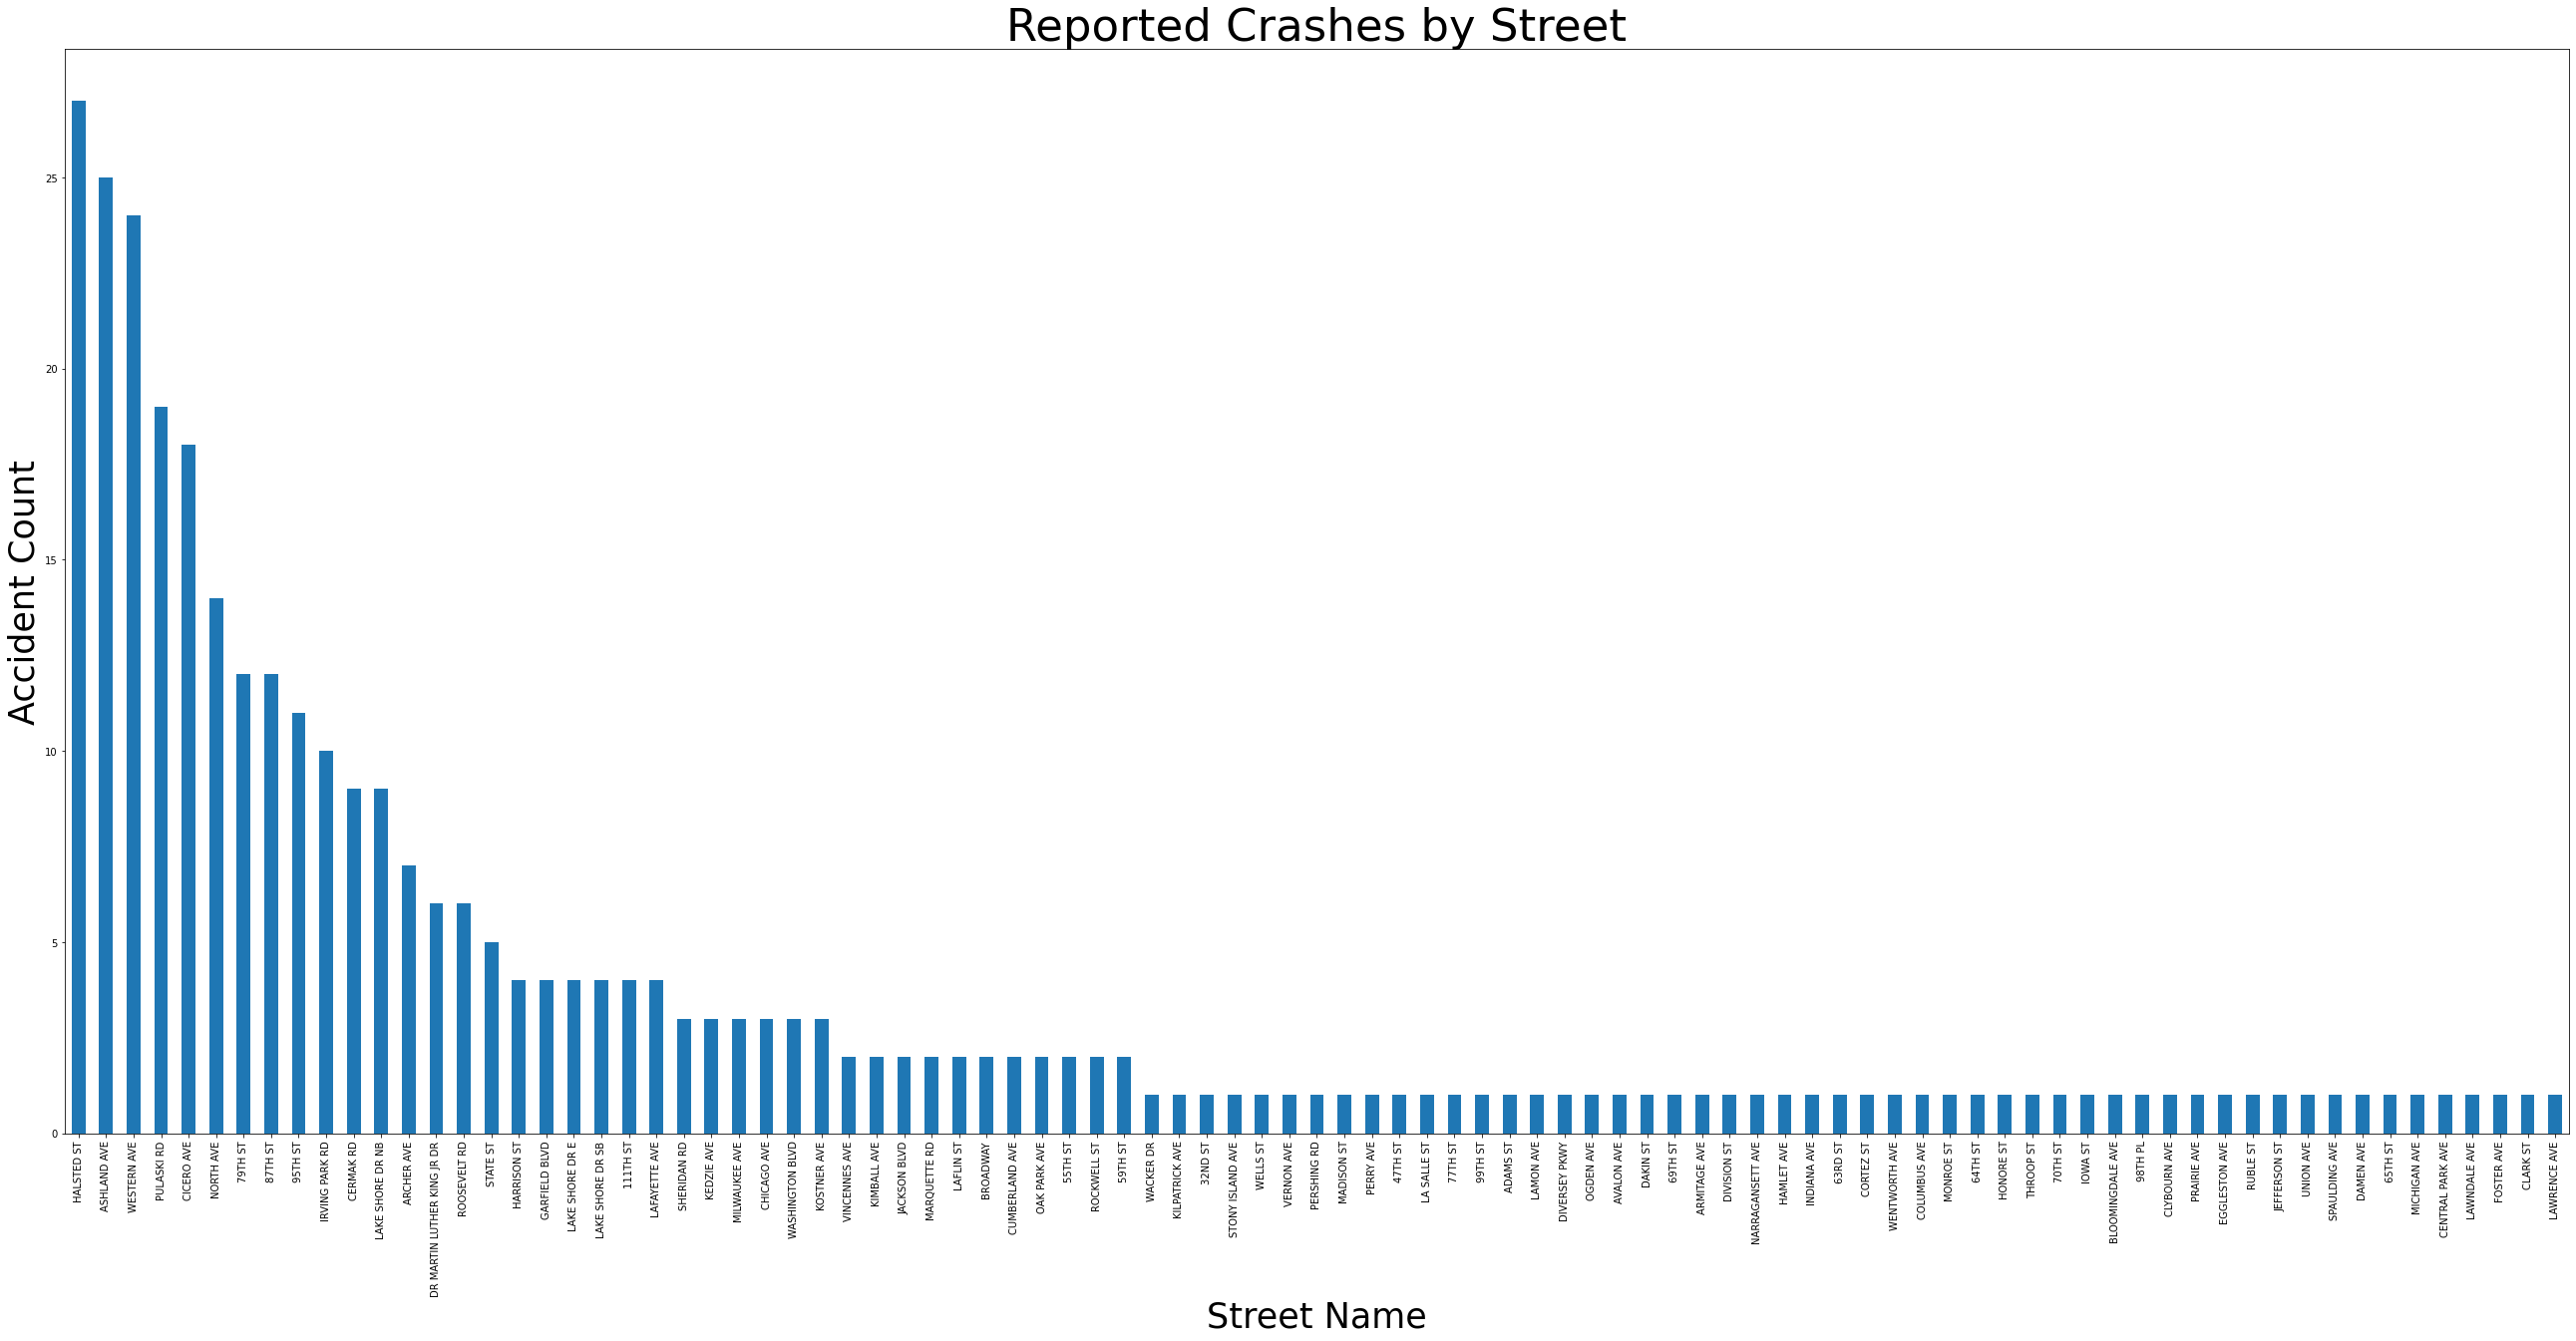

In [20]:
#dfcrfinclose.plot(x ='STREET_NAME', y='accident count', kind = 'bar')
p=pd.value_counts(dfcrfinclose['STREET_NAME']).plot(figsize=(45,20),kind='bar')
p.set_ylabel("Accident Count",fontsize = 35)
p.set_xlabel("Street Name",fontsize = 35)
p.set_title('Reported Crashes by Street',fontsize= 45)


In [21]:
dffin.columns

Index(['_last_updt', 'street', 'segmentid', '_direction', 'start_lon',
       '_lif_lat', '_lit_lon', '_lit_lat', '_traffic'],
      dtype='object')

plotting vertical line for seg 1203
plotting vertical line for seg 1203
plotting vertical line for seg 1207
plotting vertical line for seg 1207
plotting vertical line for seg 1207
plotting vertical line for seg 1207
plotting vertical line for seg 1222
plotting vertical line for seg 1228
plotting vertical line for seg 1232
plotting vertical line for seg 1232
plotting vertical line for seg 1234
plotting vertical line for seg 1234
plotting vertical line for seg 1235
plotting vertical line for seg 1235
plotting vertical line for seg 1236
plotting vertical line for seg 1240
plotting vertical line for seg 1240
plotting vertical line for seg 1241
plotting vertical line for seg 1241
plotting vertical line for seg 1242
plotting vertical line for seg 1249
plotting vertical line for seg 1249
plotting vertical line for seg 1250
plotting vertical line for seg 1251
plotting vertical line for seg 1252
plotting vertical line for seg 1254
plotting vertical line for seg 1260


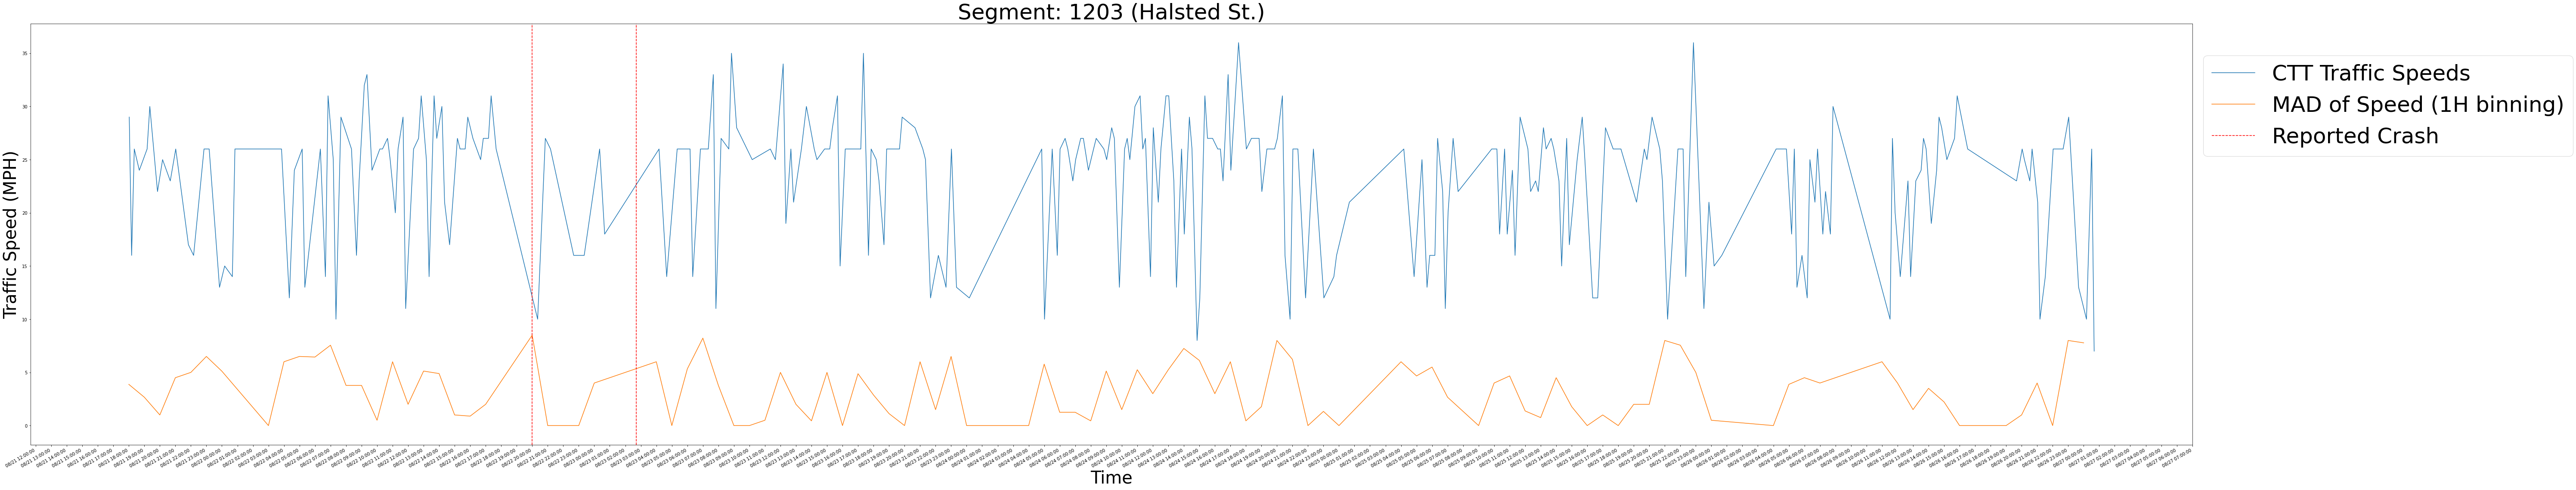

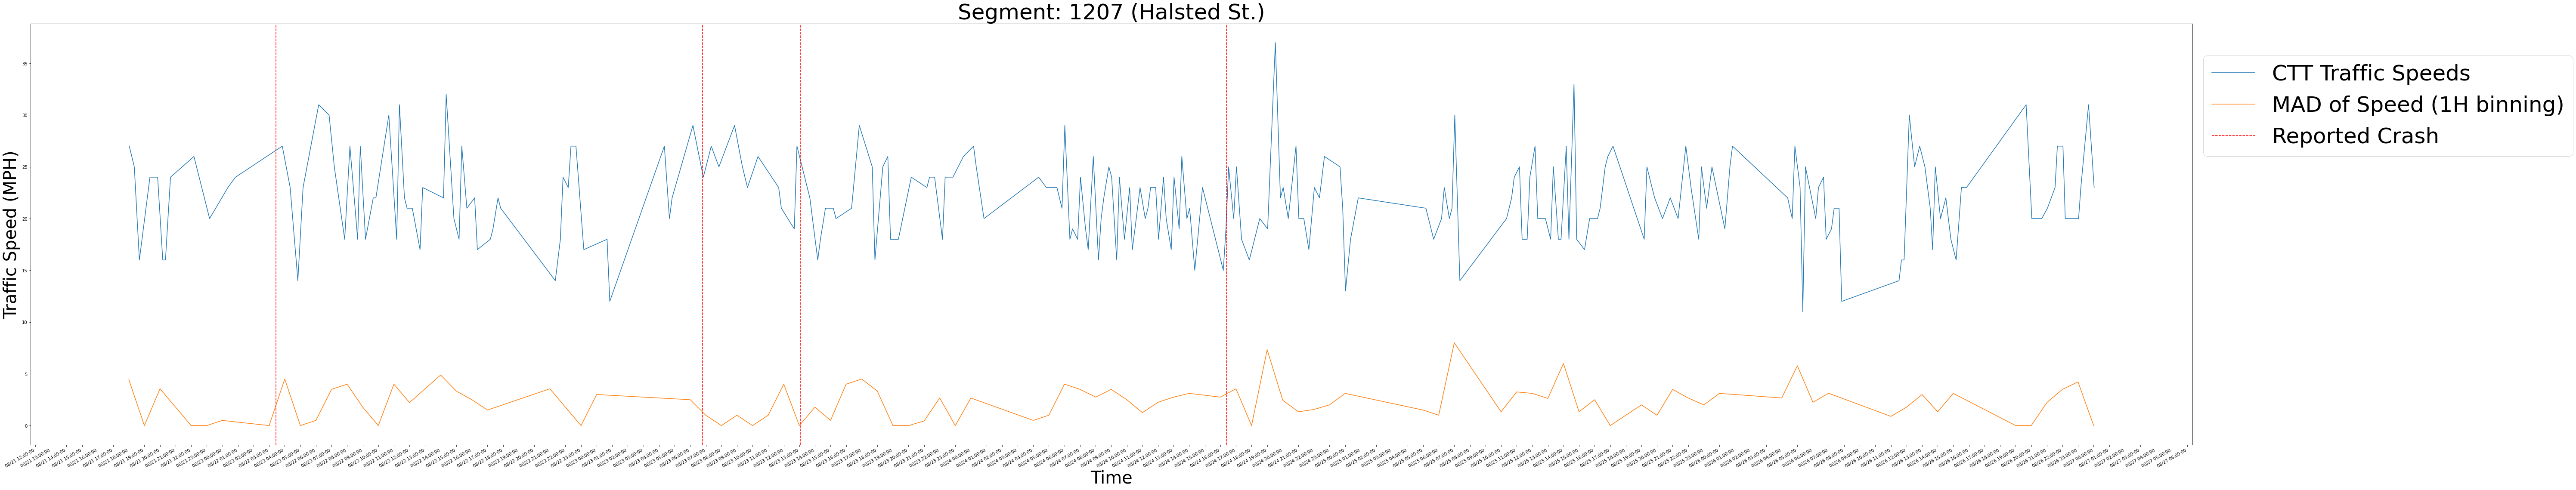

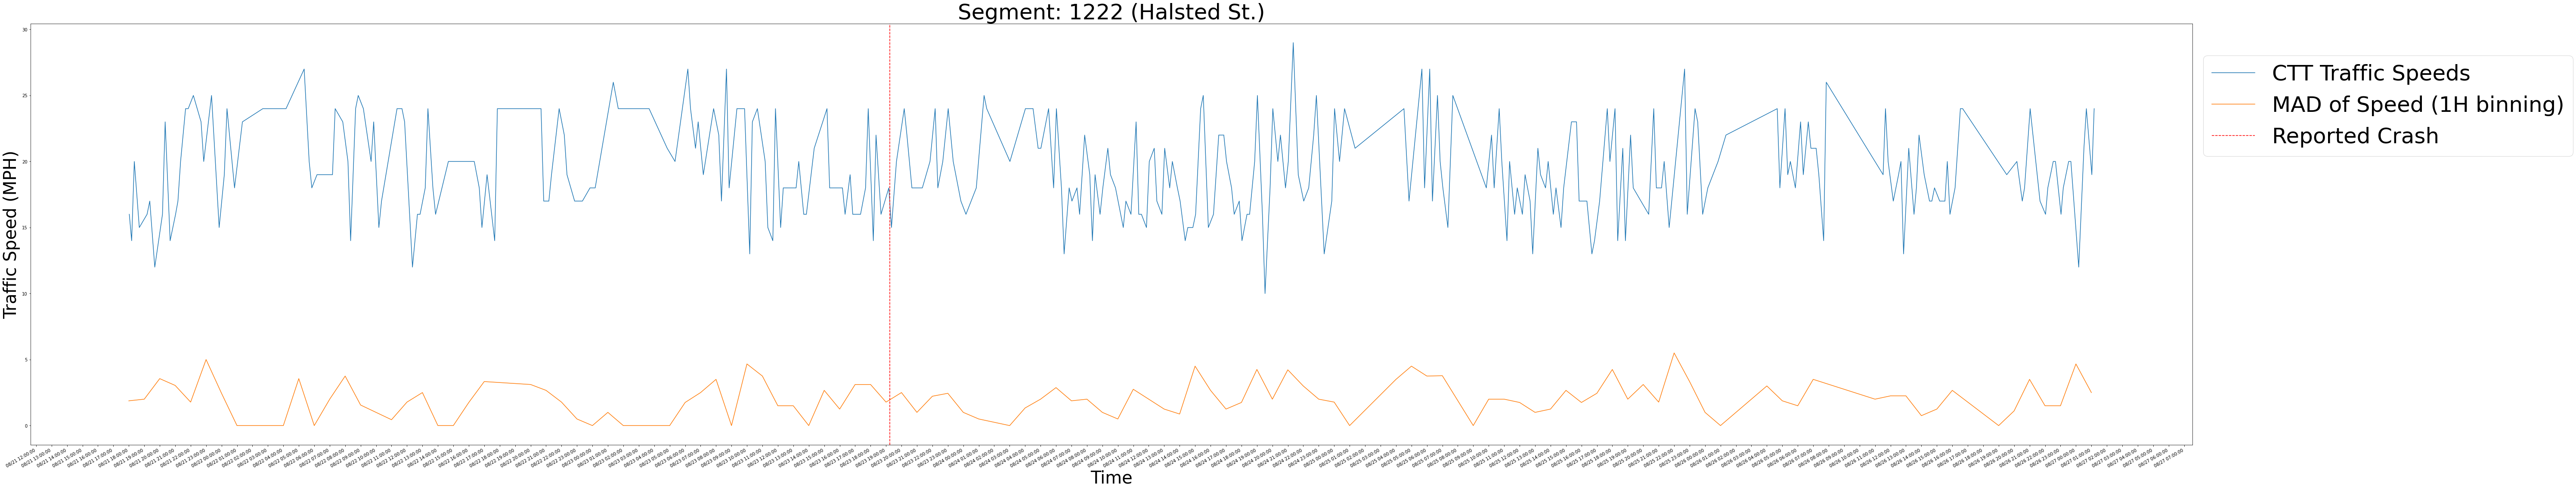

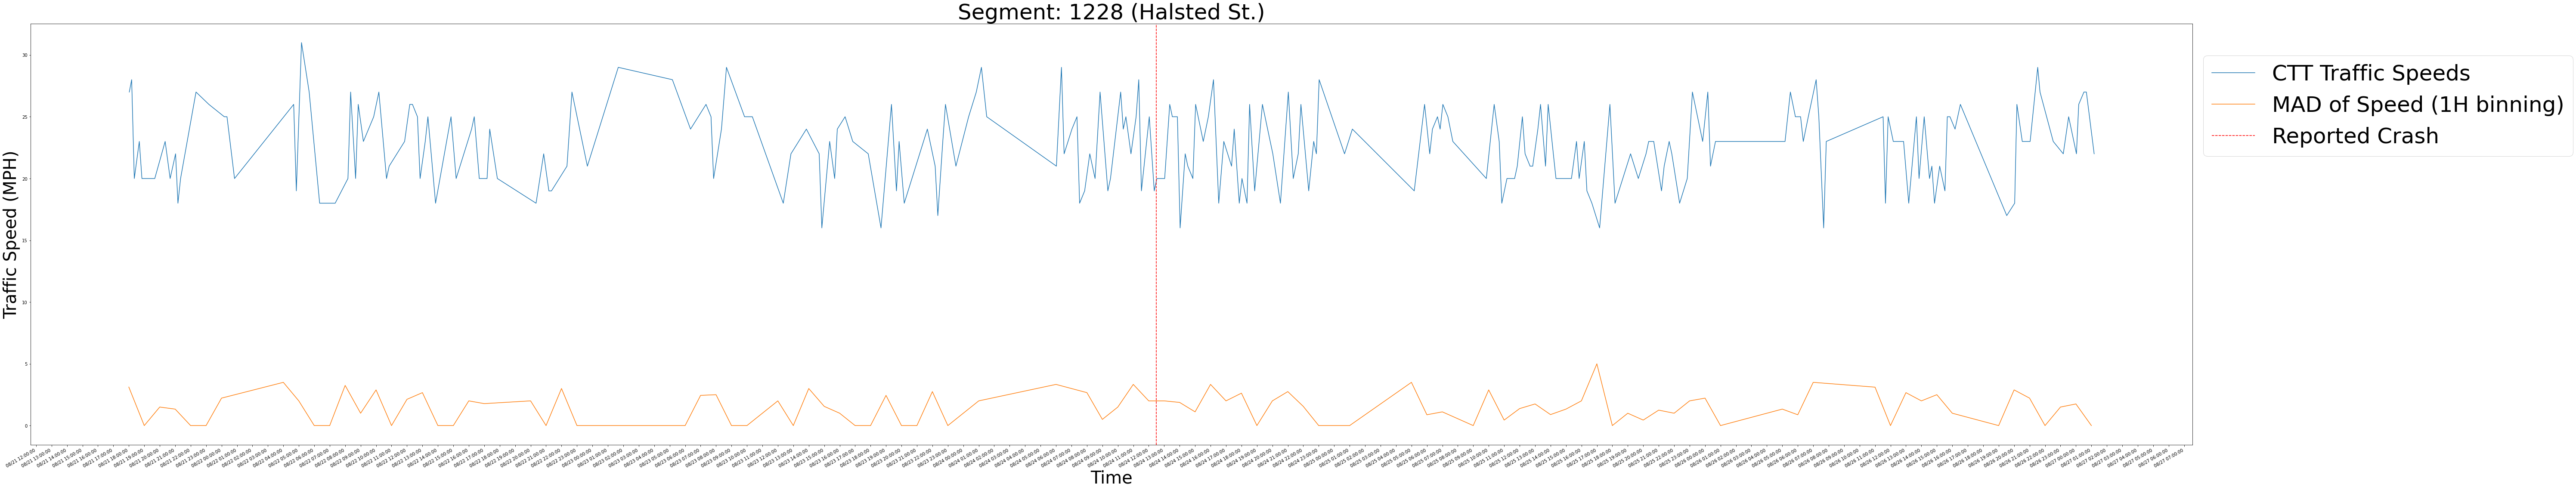

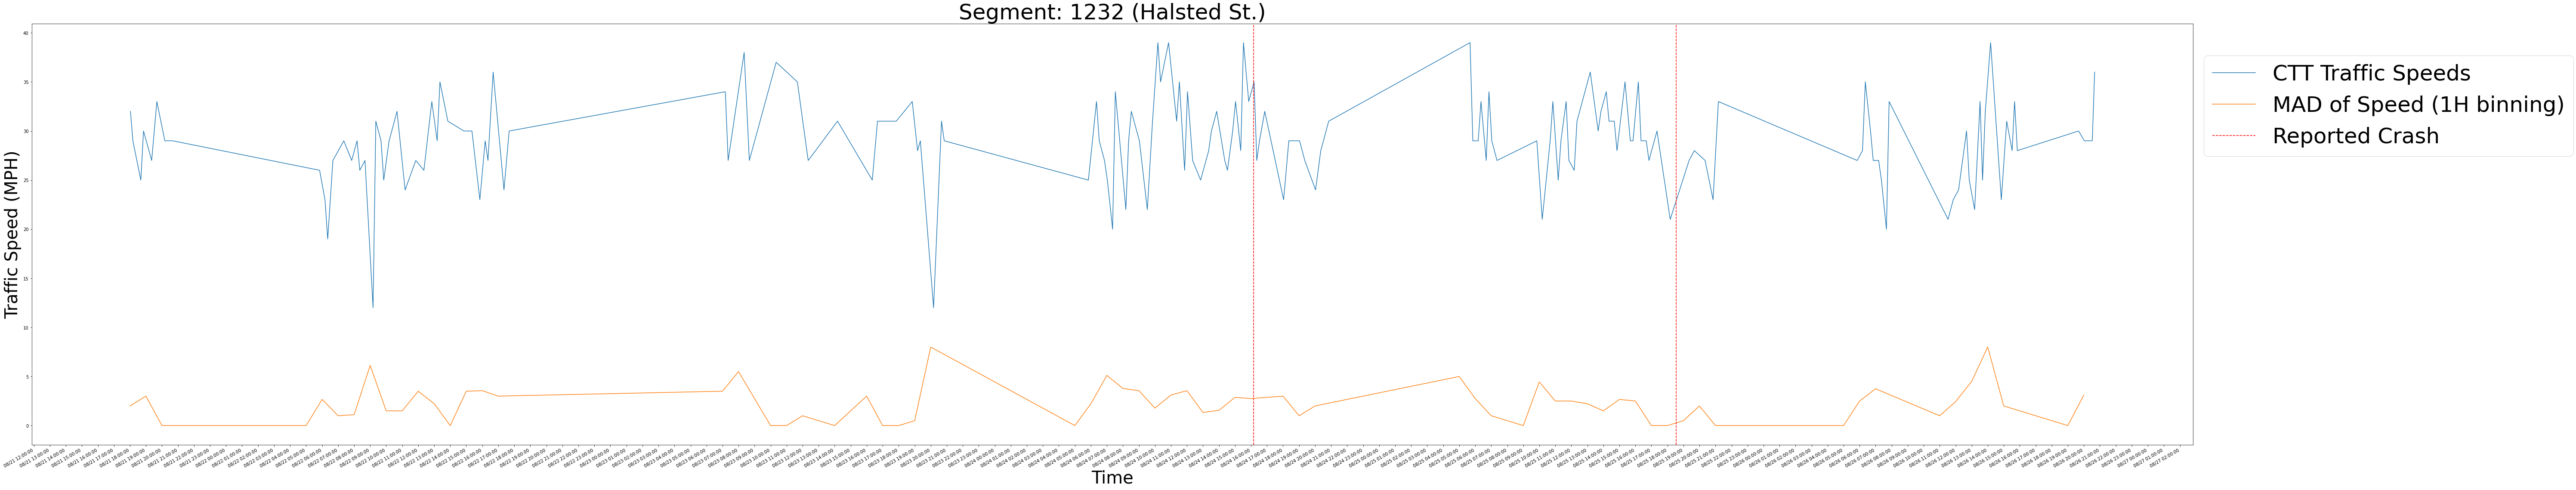

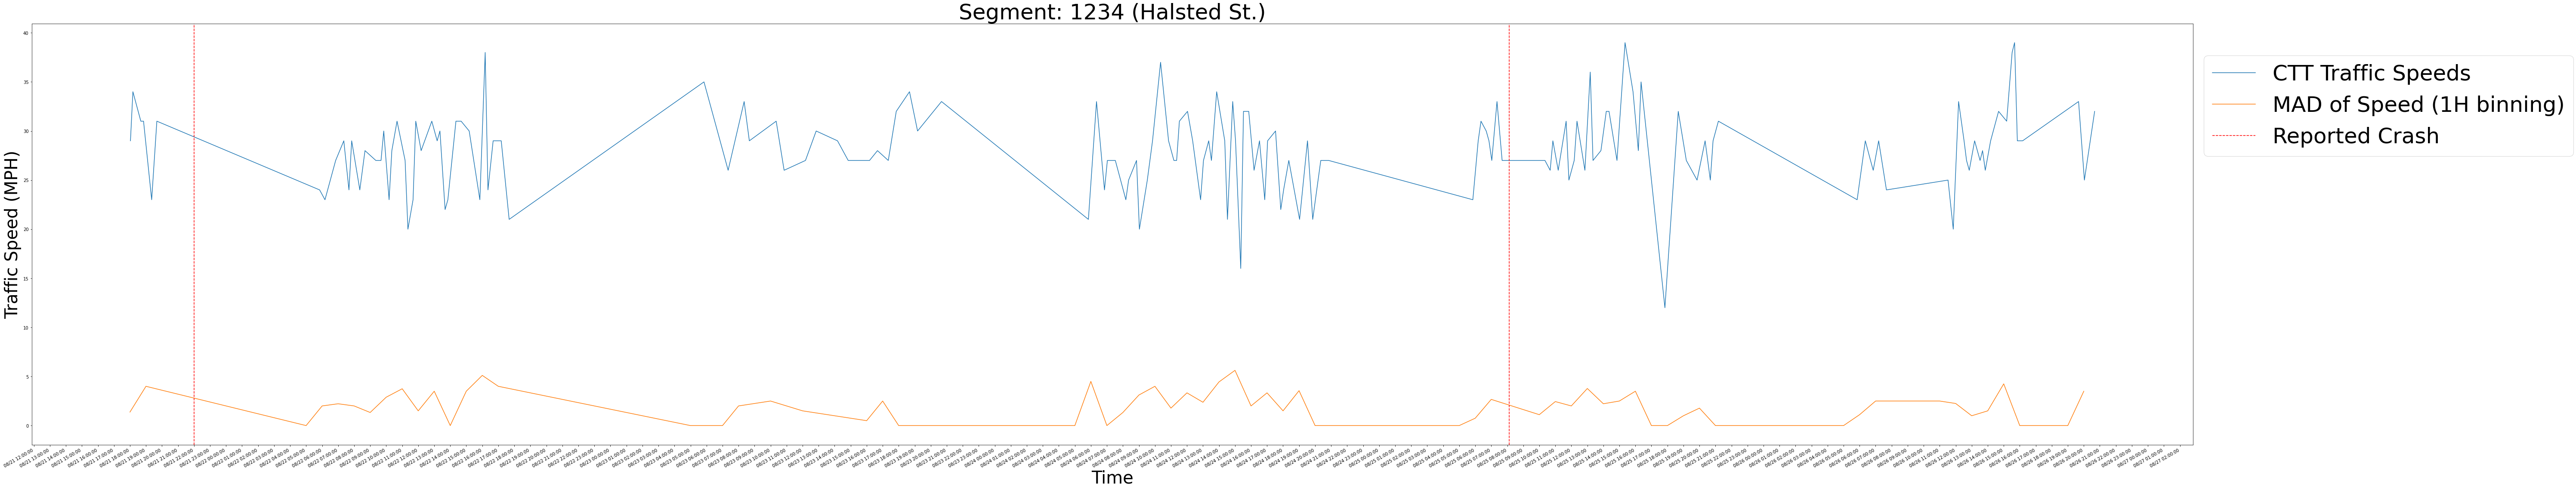

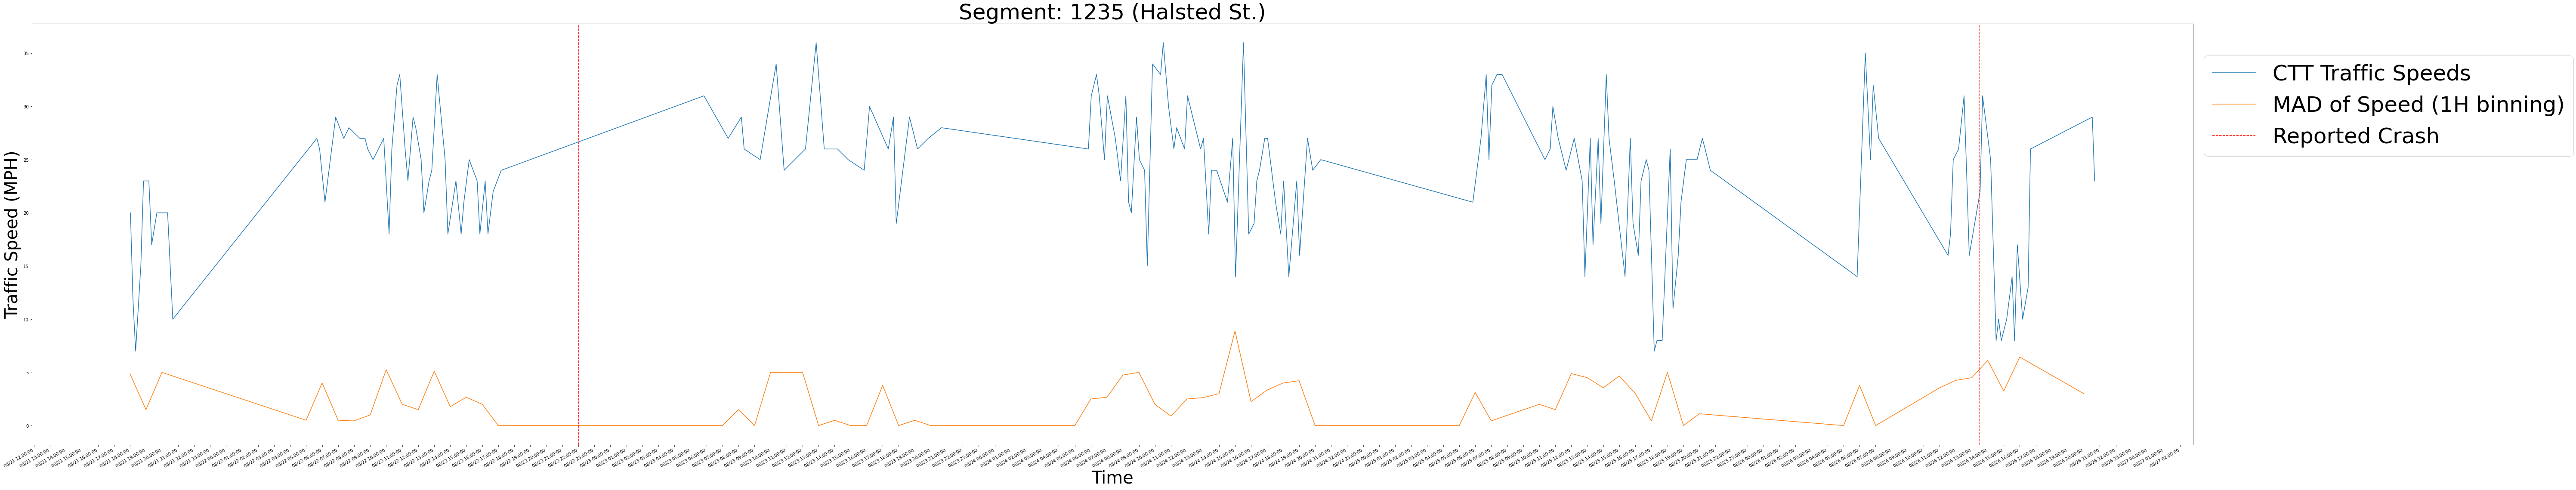

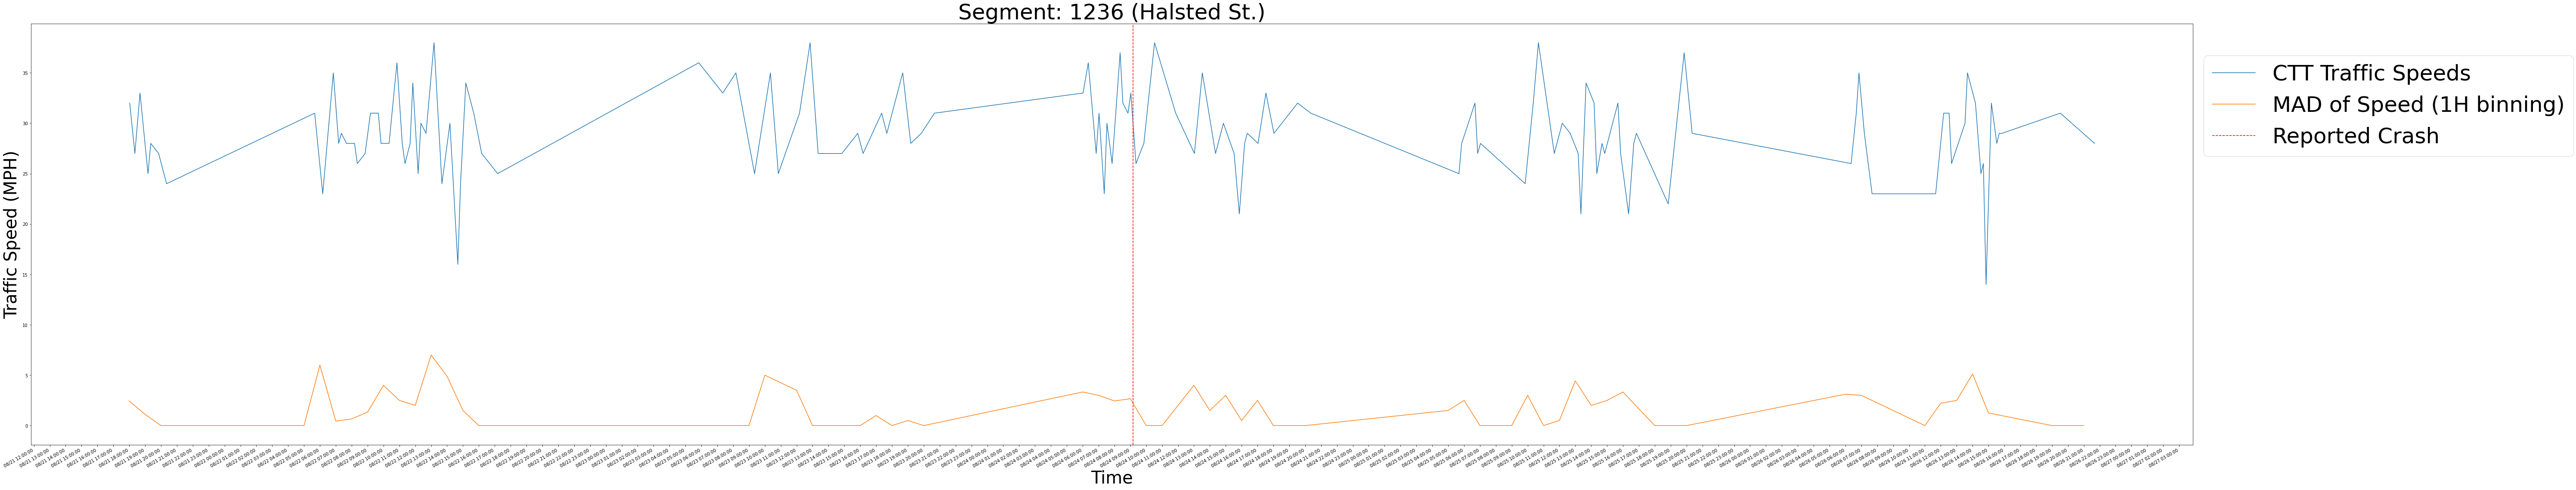

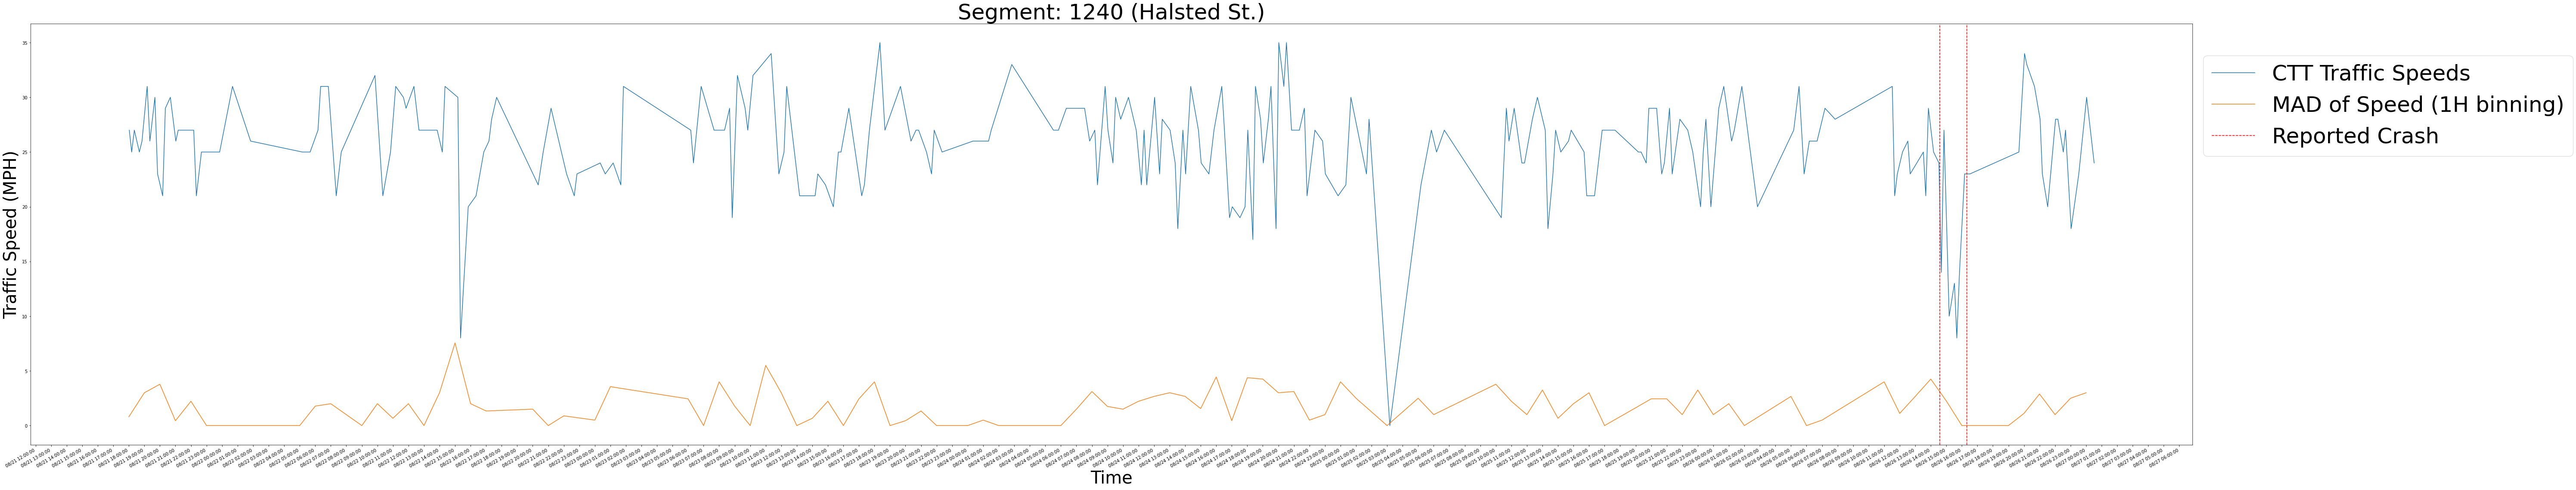

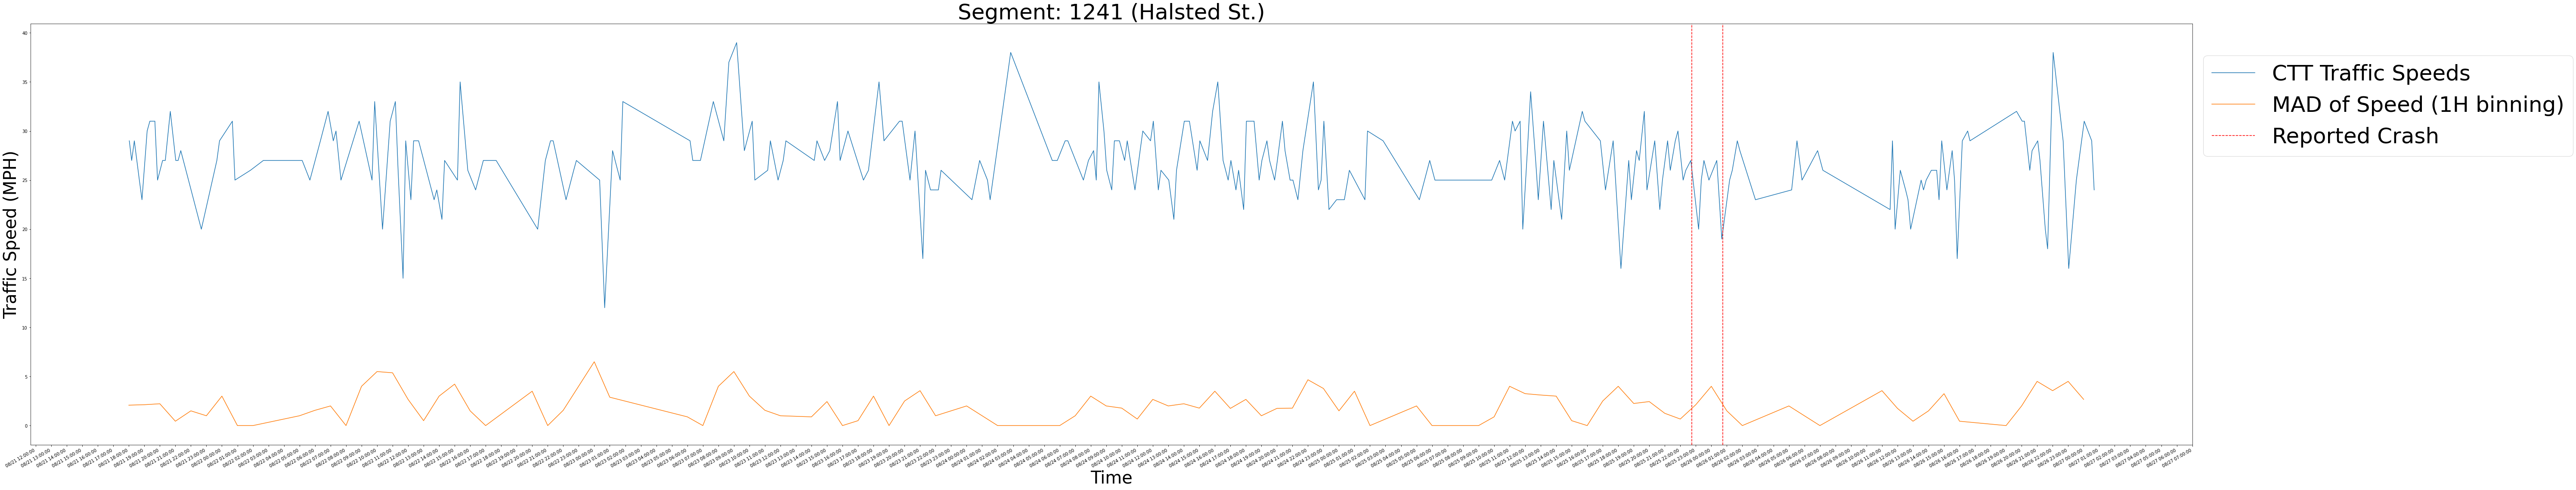

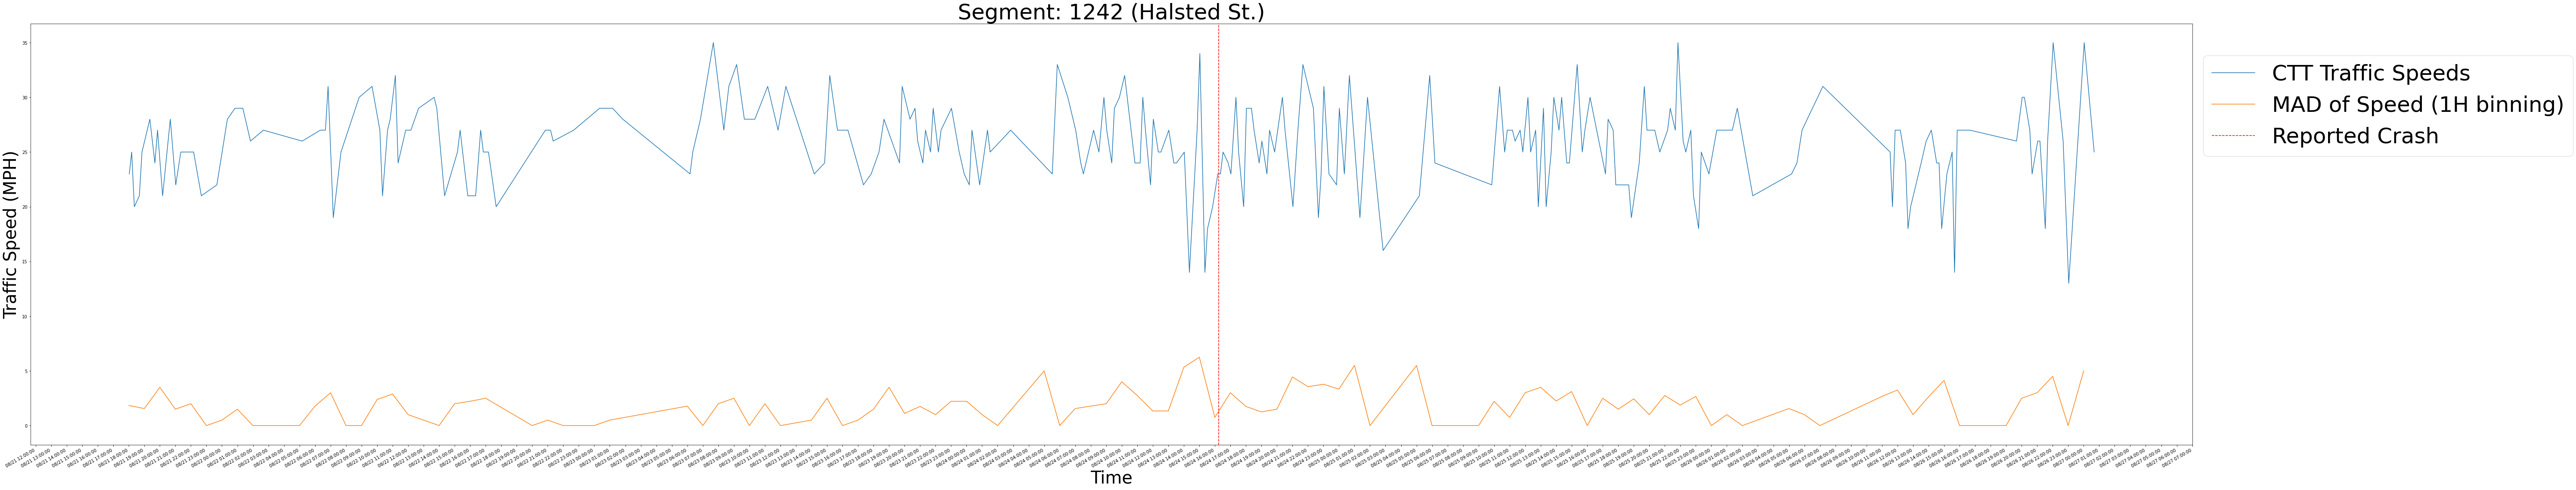

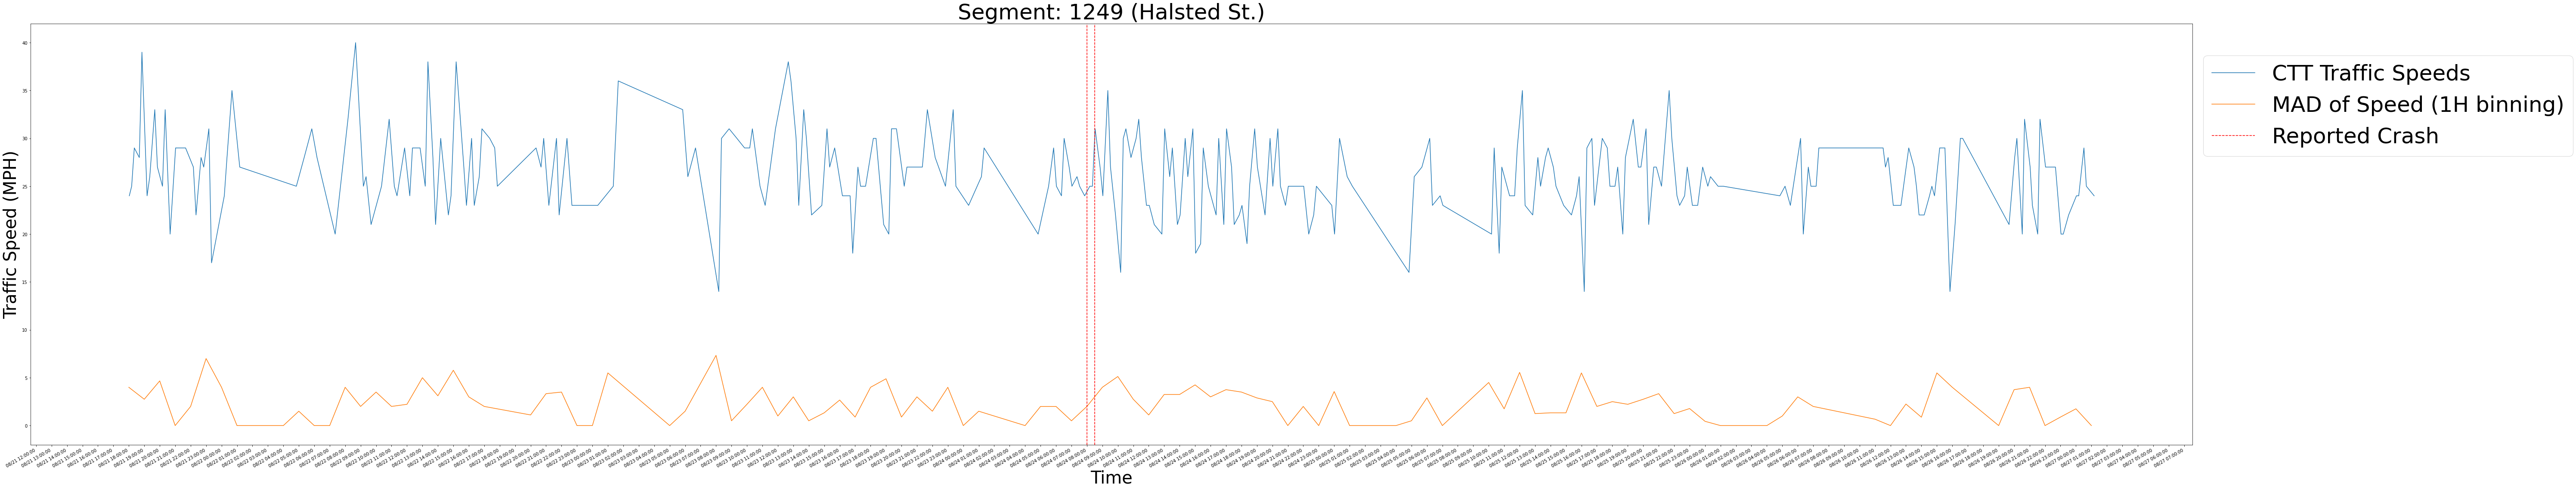

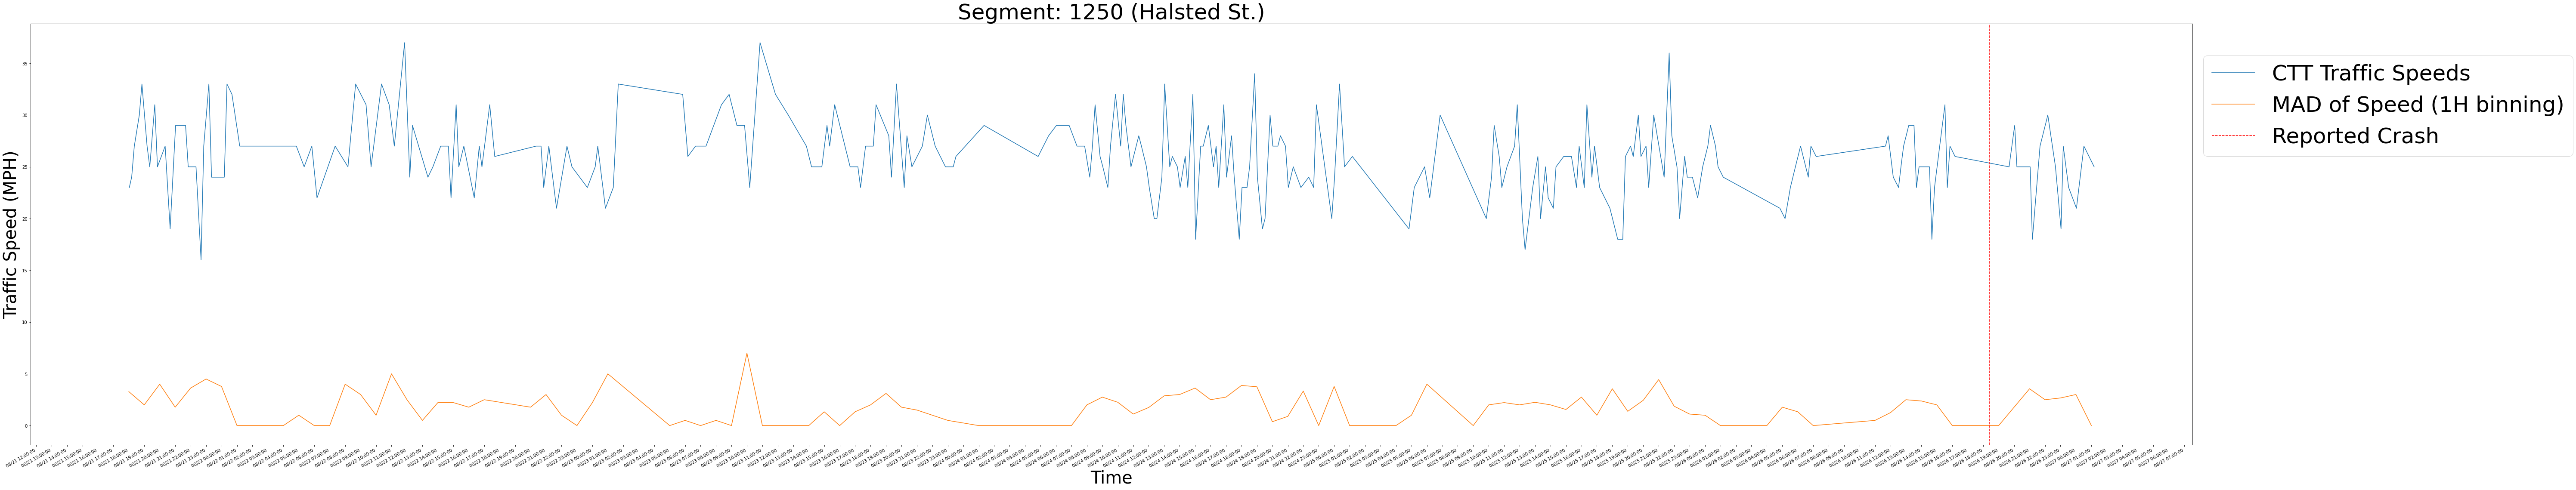

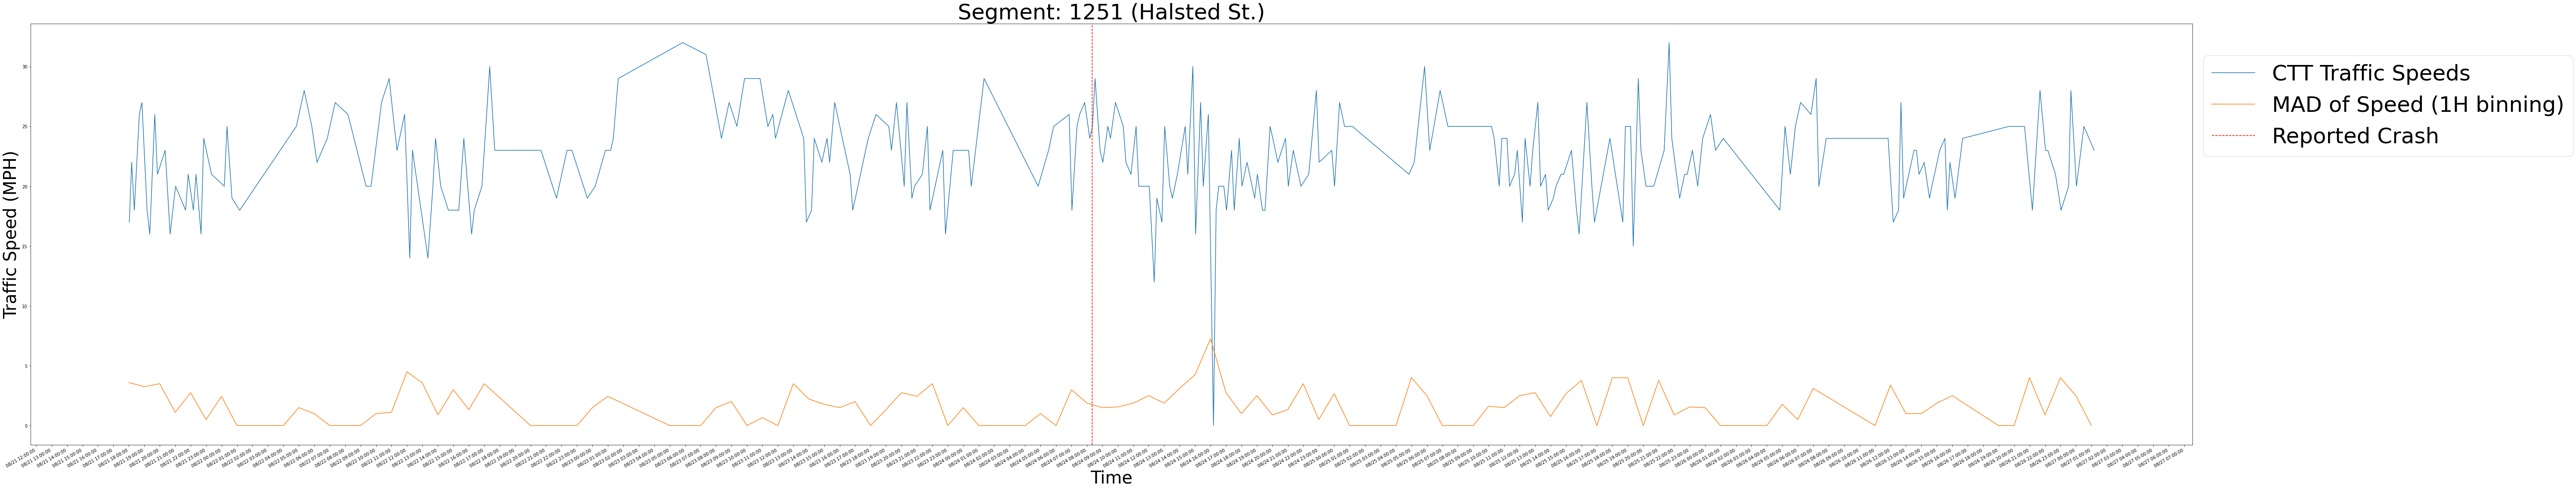

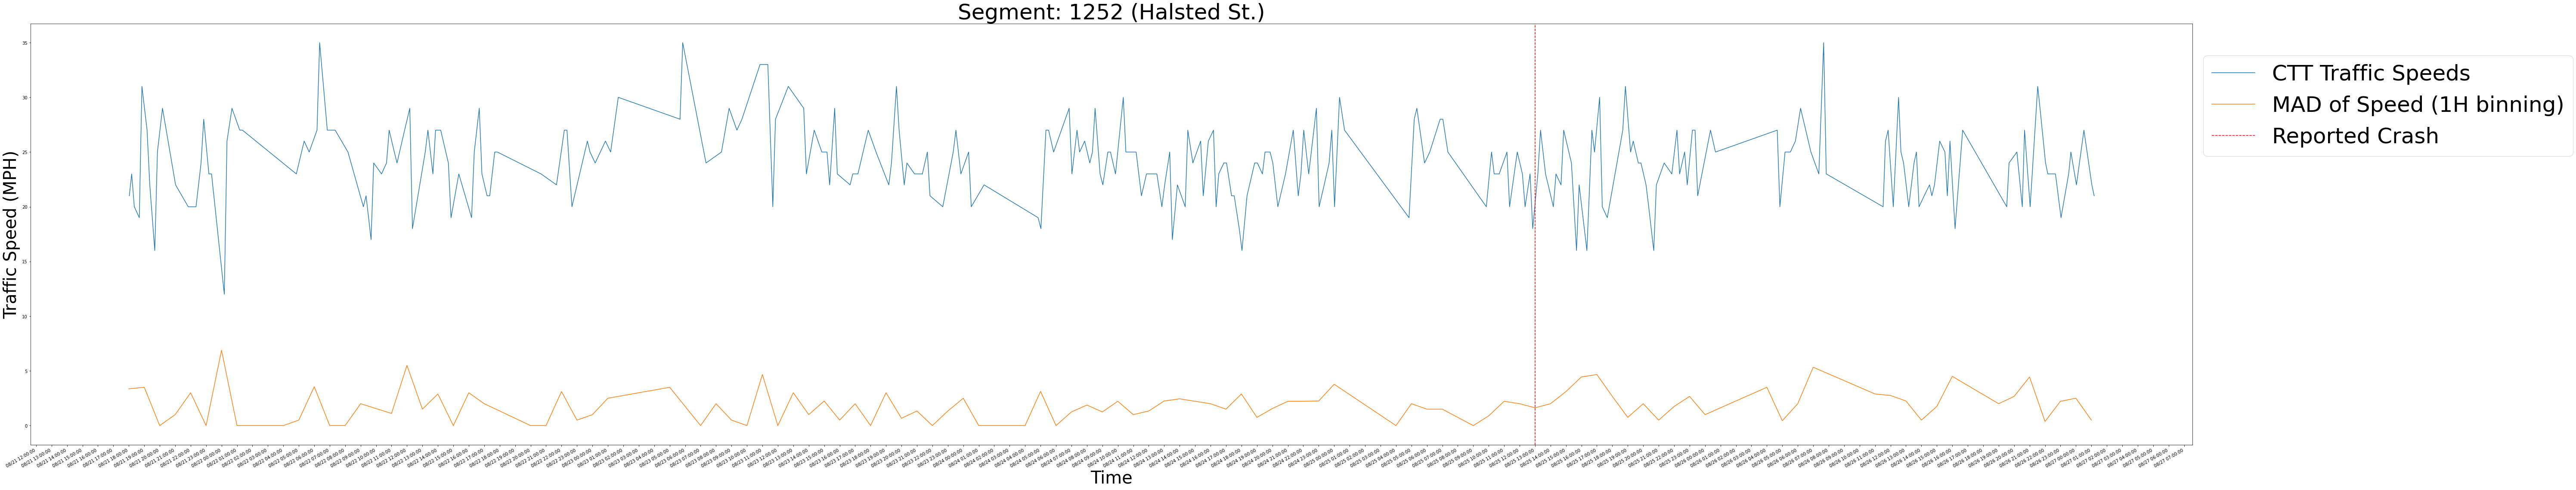

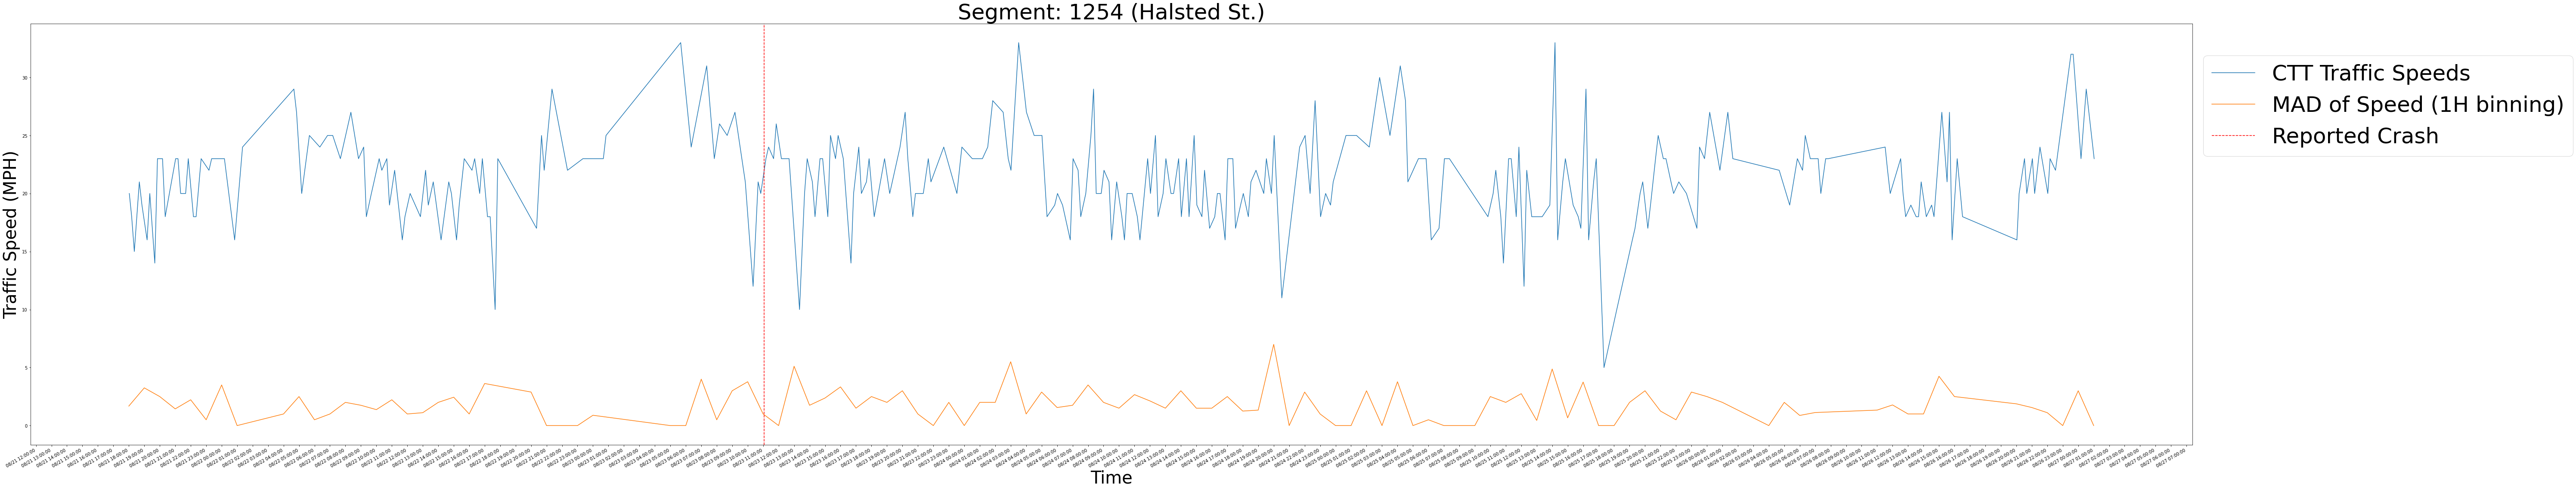

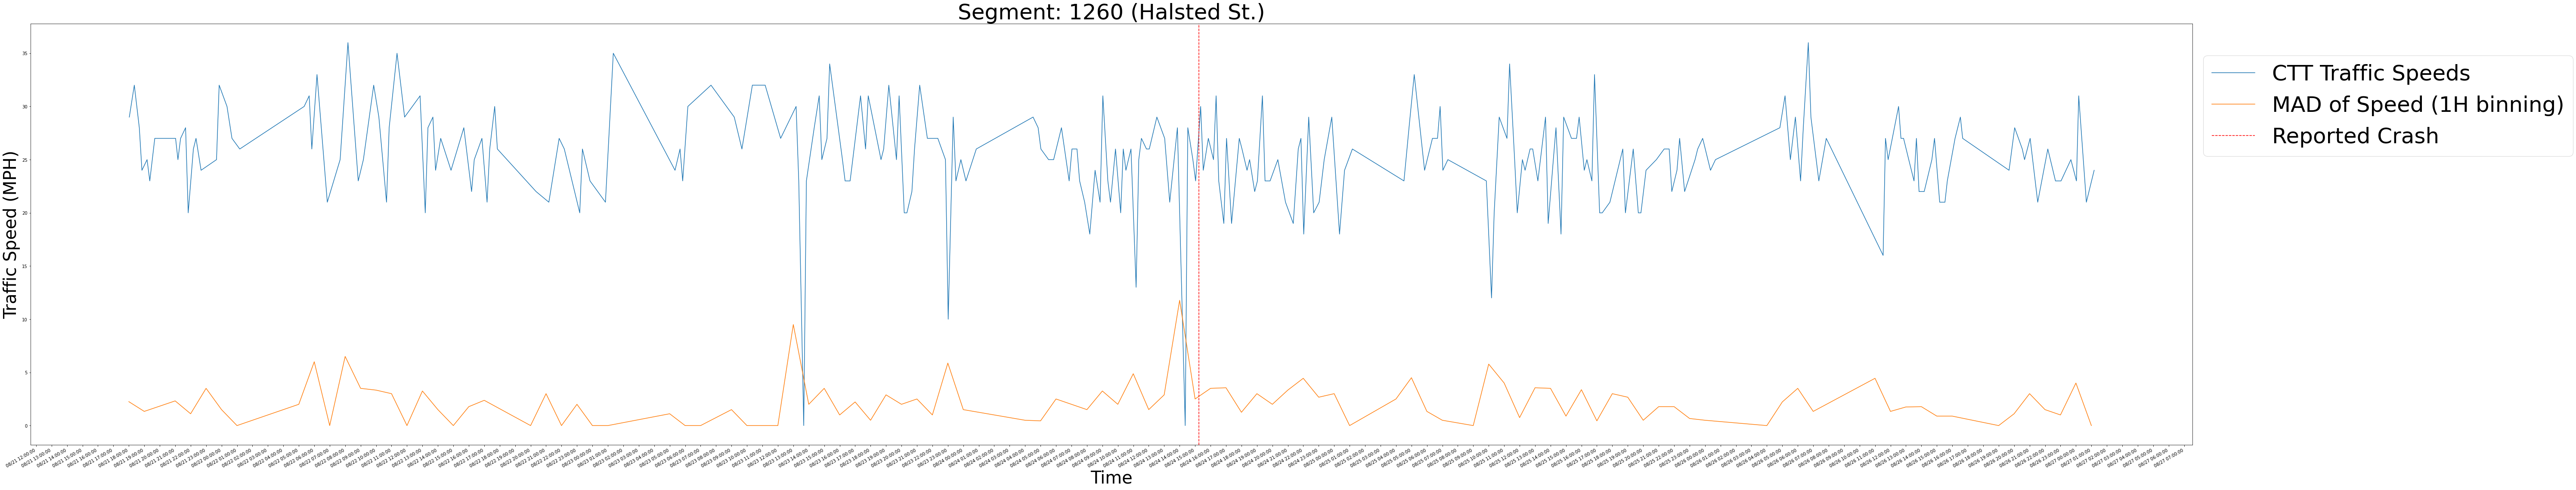

In [22]:
import warnings
warnings.filterwarnings("ignore")

hours = matplotlib.dates.HourLocator(interval = 1)
h_fmt = matplotlib.dates.DateFormatter('%H:%M:%S')
count=0

for title, group in dffin[dffin["street"]=="Halsted"].groupby('segmentid'):
    
    if not dfhalstedwclosestseg[dfhalstedwclosestseg['closest_seg']==str(title)].empty: #plot only if crash exists on seg
    
        p=group.plot(x ='_last_updt', y='_traffic',figsize=(90,20), kind = 'line') #plot ctt speed
        p.xaxis.set_major_locator(hours)
        p.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d %H:%M:%S')) #expand h_fmt to include date
    
        #plot mean absolute deviation grouped by 1 hour time periods
        group[["_last_updt","_traffic"]].groupby(pd.Grouper(key='_last_updt', freq='1H')).mad().dropna().plot(kind = 'line',legend=True,ax=p)
    
        #plot accidents per segment
        for _,row in dfhalstedwclosestseg[dfhalstedwclosestseg['closest_seg']==str(title)].iterrows():
            print("plotting vertical line for seg "+str(title))
            p.axvline(row["_last_updt"], color="red", linestyle="--")
    
        #fonts/legend configuration
        p.set_title('Segment: '+str(title)+' (Halsted St.)',fontsize= 50)
        p.set_ylabel("Traffic Speed (MPH)",fontsize = 40) #set y label, as _traffic cannot be added
        p.set_xlabel("Time",fontsize = 40) #
        p.legend(["CTT Traffic Speeds","MAD of Speed (1H binning)","Reported Crash"],prop={'size': 50},bbox_to_anchor=(1.0,0.95)) #manually set legend

